In [1]:
from __future__ import print_function

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
%matplotlib inline


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [194]:
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [55]:
train = pd.read_json('./data/train.json')
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [56]:
train.shape

(1604, 5)

In [57]:
len(train["band_2"][1])

5625

The training dataset consists of 1604 rows. Each row has data about two photos (band_1, band_2) represented by a 75x75 array 
of values

In [163]:
train["images"] = [ np.vstack((train["band_1"][t], train["band_2"][t])).T  for t in range(0, train.shape[0]) ]
## train["images"] = [ [ train["band_1"][t], train["band_2"][t] ] for t in range(0, len(train)) ]
train["images"].ndim

train["input"] = [ np.array(train.band_1[t], dtype=np.float32) for t in range(0, len(train))  ]
train.input[0]



len(train)

1604

In [193]:
# Parameters
learning_rate = 0.1
num_steps = 1000
batch_size = 128
display_step = 100

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 5625 # MNIST data input (img shape: 28*28)
num_classes = 2 # MNIST total classes (0-9 digits)



0       0
1       0
2       1
3       0
4       0
5       1
6       1
7       0
8       0
9       0
10      1
11      0
12      1
13      1
14      0
15      0
16      0
17      0
18      0
19      1
20      0
21      1
22      0
23      1
24      0
25      1
26      1
27      0
28      1
29      0
       ..
1574    0
1575    0
1576    0
1577    0
1578    0
1579    0
1580    0
1581    0
1582    0
1583    0
1584    0
1585    0
1586    0
1587    0
1588    0
1589    0
1590    0
1591    0
1592    0
1593    0
1594    0
1595    0
1596    0
1597    0
1598    0
1599    0
1600    0
1601    0
1602    0
1603    0
Name: is_iceberg, Length: 1604, dtype: int64

In [197]:
# Define the input function for training
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
y_train = to_categorical(np.array(train["is_iceberg"]))

print(y_train)

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': x_band1 }, y=y_train,
    batch_size=batch_size, num_epochs=None, shuffle=True)

[[ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


In [189]:
# Define the neural network
def neural_net(x_dict):
    # TF Estimator input is a dict, in case of multiple inputs
    x = x_dict['images']
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.layers.dense(x, n_hidden_1)
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.layers.dense(layer_1, n_hidden_2)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.layers.dense(layer_2, num_classes)
    return out_layer

In [190]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    logits = neural_net(features)
    
    # Predictions
    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [191]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Akshata\\AppData\\Local\\Temp\\tmpfk9fn78v', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}


In [192]:
# Train the Model
model.train(input_fn, steps=num_steps)

ValueError: Rank mismatch: Rank of labels (received 1) should equal rank of logits minus 1 (received 3).

In [77]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)

# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

ValueError: Could not find trained model in model_dir: C:\Users\Akshata\AppData\Local\Temp\tmpmi0zowum.

INFO:tensorflow:Restoring parameters from C:\Users\Akshata\AppData\Local\Temp\tmpjx09dhge\model.ckpt-1000


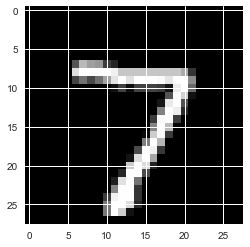

Model prediction: 7


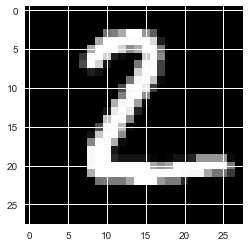

Model prediction: 2


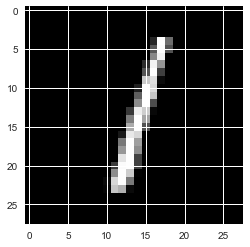

Model prediction: 1


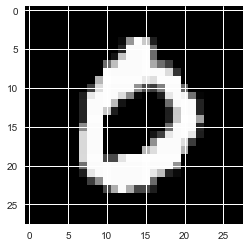

Model prediction: 0


In [28]:
# Predict single images
n_images = 4
# Get images from test set
test_images = mnist.test.images[:n_images]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))

# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])